In [1]:
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(os.listdir("../input"))
print('cuda: {}, device: {}'.format(use_cuda, device))
print('pytorch version: {}'.format(torch.__version__))

['train.csv', 'sample_submission.csv', 'test.csv']
cuda: True, device: cuda
pytorch version: 1.0.1.post2


In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [3]:
class MNIST(Dataset):
    def __init__(self, file_path, transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])):
        df = pd.read_csv(file_path)
        if df.shape[1] == 784:
            # test data
            # self.X = df.values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.X = df.values.reshape(-1, 28, 28, 1).astype(np.uint8)
            self.y = None
        else:
            # training data
            # self.X = df.iloc[:, 1:].values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.X = df.iloc[:, 1:].values.reshape(-1, 28, 28, 1).astype(np.uint8)
            self.y = torch.from_numpy(df.iloc[:, 0].values)

        self.transform = transform

    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [4]:
batch_size = 64
train_dataset = MNIST('../input/train.csv', transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
]))
test_dataset = MNIST('../input/test.csv')

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

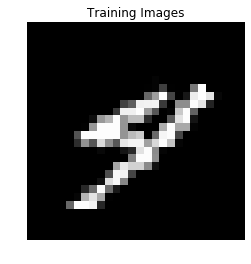

In [5]:
img = next(iter(train_loader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(img[0].to(device)[:1], padding=0, normalize=True).cpu(),(1,2,0)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(512, 10),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    

In [9]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
if use_cuda:
    model = model.to(device)
    criterion = criterion.to(device)
print(model)

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [11]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:
n_epochs = 20
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, train_loader)

Train Epoch: 1 [0/42000 (0%)]	Loss: 2.335302
Train Epoch: 1 [6400/42000 (15%)]	Loss: 0.543683
Train Epoch: 1 [12800/42000 (30%)]	Loss: 0.210248
Train Epoch: 1 [19200/42000 (46%)]	Loss: 0.171113
Train Epoch: 1 [25600/42000 (61%)]	Loss: 0.144800
Train Epoch: 1 [32000/42000 (76%)]	Loss: 0.086634
Train Epoch: 1 [38400/42000 (91%)]	Loss: 0.120456

Test set: Average loss: 0.1272, Accuracy: 40417/42000 (96%)

Train Epoch: 2 [0/42000 (0%)]	Loss: 0.261529
Train Epoch: 2 [6400/42000 (15%)]	Loss: 0.191548
Train Epoch: 2 [12800/42000 (30%)]	Loss: 0.230548
Train Epoch: 2 [19200/42000 (46%)]	Loss: 0.091214
Train Epoch: 2 [25600/42000 (61%)]	Loss: 0.179297
Train Epoch: 2 [32000/42000 (76%)]	Loss: 0.109263
Train Epoch: 2 [38400/42000 (91%)]	Loss: 0.229464

Test set: Average loss: 0.0766, Accuracy: 40985/42000 (98%)

Train Epoch: 3 [0/42000 (0%)]	Loss: 0.187596
Train Epoch: 3 [6400/42000 (15%)]	Loss: 0.089422
Train Epoch: 3 [12800/42000 (30%)]	Loss: 0.174470
Train Epoch: 3 [19200/42000 (46%)]	Loss: 0.0

In [19]:
def prediciton(test_loader):
    model.eval()
    test_pred = torch.LongTensor()
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True).cpu()
            test_pred = torch.cat((test_pred, pred), dim=0)
    return test_pred

In [20]:
test_pred = prediciton(test_loader)
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

In [21]:
print(out_df)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
5            6      7
6            7      0
7            8      3
8            9      0
9           10      3
10          11      5
11          12      7
12          13      4
13          14      0
14          15      4
15          16      3
16          17      3
17          18      1
18          19      9
19          20      0
20          21      9
21          22      1
22          23      1
23          24      5
24          25      7
25          26      4
26          27      2
27          28      7
28          29      4
29          30      7
...        ...    ...
27970    27971      5
27971    27972      0
27972    27973      4
27973    27974      8
27974    27975      0
27975    27976      3
27976    27977      6
27977    27978      0
27978    27979      1
27979    27980      9
27980    27981      3
27981    27982      1
27982    27983      1
27983    2

In [24]:
out_df.to_csv('submission.csv', index=False)